# Visualization Assignment 2

## Load packages and dataset

In [443]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import finnhub
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from datetime import datetime, timezone
from sklearn.cross_decomposition import CCA
from scipy import stats

> The following code chunk is to import the SPI_KEY. Please **remove it** for personal use:

In [444]:
cd ..


F:\OneDrive\OneDrive - The University of Western Ontario\DA_Algo


In [445]:
from etl_utils.etl_config import FINNHUB_CONFIG # Comment this and add your owe API token
API_token = FINNHUB_CONFIG["API_KEY"] # Set your own API_key here as string

## Pre-load functions for simple extact data from Finnhub:

In [446]:
def convert_datetime(date_time):
    """
    Convert the datetime from local timezone to UTC timestamp.

    :param date_time: (datetime/str) 'Y-m-d H:M:S'
    :return: (timestamp)
    """

    if isinstance(date_time, datetime):  # Directly convert to timestamp if input datetime
        dt_stamp = int(date_time.astimezone(timezone.utc).timestamp())
    else:
        try:
            date_time = datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
            dt_stamp = int(date_time.astimezone(timezone.utc).timestamp())
        except Exception:
            raise Exception(
                "Please keep the input string in proper form as 'Y-m-d H:M:S'.")
    return dt_stamp

In [447]:
def extract_candles(symbol, dt_start, dt_end, resolution):
    """
    Extract candles data from Finnhub.io and format the output as DataFrame.

    :param symbol: stack abbreviation
    :param dt_start: (datetime/str) 'Y-m-d H:M:S'
    :param dt_end: (datetime/str) 'Y-m-d H:M:S'
    :param resolution: 'D' for daily level, 1 for minite level.
    :return: DataFrame
    """
    finnhub_client = finnhub.Client(api_key=API_token)
    res = finnhub_client.stock_candles(symbol, resolution, 
                                       convert_datetime(dt_start), 
                                       convert_datetime(dt_end))

    if res['s'] == 'no_data':
        return pd.DataFrame()
    else:
        finnhub_data = pd.DataFrame(res)
        finnhub_data["symbol"] = symbol
        # Convert the timestamp column to readable form:
        finnhub_data["t"] = finnhub_data["t"].apply(lambda x:
                                                    datetime.fromtimestamp(x).astimezone(timezone.utc))
        # Make sure the volume column are all integers:
        finnhub_data["v"] = finnhub_data["v"].apply(lambda x: int(x))
        # Rename the columns:
        finnhub_data = finnhub_data.rename({'c':'close_price', 'h':'high_price',
                                            'l':'low_price', 'o':'open_price',
                                            's':'status', 't':'timestamp', 'v':'volume'}, axis=1)
        return finnhub_data
            
           

Extract source data:

In [448]:
from_dt = "2020-09-15 00:00:00"
to_dt = "2020-09-16 00:00:00"
stack_symbol = "THRM"

res = extract_candles(stack_symbol, from_dt, to_dt, 1)
res = res.sort_values("timestamp")

Data overview:

In [449]:
res.info()
print("Datetime range from {} to {}".format(res["timestamp"].min(), res["timestamp"].max()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   close_price  170 non-null    float64            
 1   high_price   170 non-null    float64            
 2   low_price    170 non-null    float64            
 3   open_price   170 non-null    float64            
 4   status       170 non-null    object             
 5   timestamp    170 non-null    datetime64[ns, UTC]
 6   volume       170 non-null    int64              
 7   symbol       170 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(2)
memory usage: 12.0+ KB
Datetime range from 2020-09-15 13:30:00+00:00 to 2020-09-15 20:00:00+00:00


## Question 1

Get 1-day trading data (open, close, high, low and volume) with 1 minute interval for Therma Bright Inc. (THRM.V).   
Plot candle stick plot and VWAP in one figure using the 1-day data above.  [20 points]
(10 points for candle stick plot and 10 points for VWAP)

### Step 1. Calculate VWAP:

In [450]:
df_stack_min = res.loc[:, ["timestamp", "open_price", "high_price", "low_price", "close_price", "volume"]]

def cal_avg(row):
    return (row["high_price"] + row["low_price"] + row["close_price"])/3

df_stack_min["avg_price"] = df_stack_min.apply(cal_avg, axis=1) # calculate average price
df_stack_min["cum_vol"] = df_stack_min["volume"].cumsum()  # calculate cumulative volume
df_stack_min["avg_tot_price"] = df_stack_min["volume"] * df_stack_min["avg_price"] # Calculate Average Price * Volume
df_stack_min["cum_tot_price"] = df_stack_min["avg_tot_price"].cumsum() #  Calculate Cumulative Average Total Price
df_stack_min["VWAP"] = df_stack_min["cum_tot_price"] / df_stack_min["cum_vol"] # Calculate VWAP

In [451]:
df_stack_min.head()

,timestamp,open_price,high_price,low_price,close_price,volume,avg_price,cum_vol,avg_tot_price,cum_tot_price,VWAP
0,2020-09-15 13:30:00+00:00,44.460,44.460,44.460,44.460,587,44.460000,587,26098.020000,26098.020000,44.460000
1,2020-09-15 13:35:00+00:00,44.580,44.580,44.530,44.530,622,44.546667,1209,27708.026667,53806.046667,44.504588
2,2020-09-15 13:38:00+00:00,44.485,44.485,44.485,44.485,101,44.485000,1310,4492.985000,58299.031667,44.503078
3,2020-09-15 13:42:00+00:00,44.415,44.415,44.415,44.415,132,44.415000,1442,5862.780000,64161.811667,44.495015
4,2020-09-15 13:44:00+00:00,44.590,44.590,44.590,44.590,112,44.590000,1554,4994.080000,69155.891667,44.501861


### Step 2. Plotting

In [452]:
fig = go.Figure()

fig.add_trace(
    go.Candlestick(x=df_stack_min['timestamp'], open=df_stack_min['open_price'],
                   high=df_stack_min['high_price'],low=df_stack_min['low_price'],
                   close=df_stack_min['close_price'], name="Stack Candles"))

fig.add_trace(
    go.Scatter(x=df_stack_min['timestamp'], y=df_stack_min['VWAP'], mode="lines",
               line=go.scatter.Line(color='blue'),name='VWAP'))

fig.update_layout(
    title='The Candle Stick and VWAP Trends of Stock {}'.format(stack_symbol),
    yaxis_title='{} Stock Price'.format(stack_symbol),
    xaxis_title='Time')

fig.show()

## Question 2

Get daily trading data (open, close, high, low and volume) from 2018-01-01 to 2020-12-31 for Therma Bright Inc. (THRM.V).  
Plot candle stick plot and 30-day and 100-day exponential moving averages on one figure. [20 points]
(10 points for candle stick plot and 10 points for moving averages)

In [453]:
from_dt = "2017-01-01 00:00:00"
to_dt = "2020-12-31 00:00:00"
stack_symbol = "THRM"

res_q2 = extract_candles(stack_symbol, from_dt, to_dt, "D")
res_q2 = res_q2.sort_values("timestamp")
df_stack_daily = res_q2.loc[:, ["timestamp", "open_price", "high_price", "low_price", "close_price", "volume"]]

### Step 1. Calculate Exponential Moving Average

In [454]:
# Exponential moving average:
df_stack_daily["ewm_30"] = df_stack_daily["close_price"].ewm(span=30, adjust=False).mean()
df_stack_daily["ewm_100"] = df_stack_daily["close_price"].ewm(span=100, adjust=False).mean()
print(df_stack_daily.head())

                  timestamp  open_price  high_price  low_price  close_price  \
0 2017-01-03 00:00:00+00:00       34.35       34.85      33.70        33.95   
1 2017-01-04 00:00:00+00:00       34.05       35.70      34.05        35.70   
2 2017-01-05 00:00:00+00:00       35.85       35.85      34.15        34.25   
3 2017-01-06 00:00:00+00:00       34.40       34.80      34.00        34.10   
4 2017-01-09 00:00:00+00:00       34.00       34.10      33.50        33.90   

   volume     ewm_30    ewm_100  
0  199446  33.950000  33.950000  
1  231234  34.062903  33.984653  
2  283916  34.074974  33.989908  
3  252292  34.076589  33.992088  
4  245566  34.065196  33.990264  


### Step 2. Ploting

In [455]:
fig = go.Figure()

fig.add_trace(
    go.Candlestick(x=df_stack_daily['timestamp'], open=df_stack_daily['open_price'],
                   high=df_stack_daily['high_price'],low=df_stack_daily['low_price'],
                   close=df_stack_daily['close_price'], name="Stack Candles"))

fig.add_trace(
    go.Scatter(x=df_stack_daily['timestamp'], y=df_stack_daily['ewm_30'], mode="lines",
               line=go.scatter.Line(color='#17becf'),name='30-day EMA'))

fig.add_trace(
    go.Scatter(x=df_stack_daily['timestamp'], y=df_stack_daily['ewm_100'], mode="lines",
               line=go.scatter.Line(color='#9467bd'),name='100-day EMA'))

fig.update_layout(
    title='The Candle Stick and EMA (Expoinential Moving Average) Trends of Stock {}'.format(stack_symbol),
    yaxis_title='{} Stock Price'.format(stack_symbol),
    xaxis_title='Time')

fig.show()

## Question 3
Use the same data in Question 2. 

(1) Calculate daily return (return = log(today close/previous close)) [5 points]

(2) Conduct the hypothesis testing to check if the distribution of daily return is normal.  [15 points]


### Step 1. Calculate Daily Return

In [456]:
import math
df_stack_daily["daily_return"] = (df_stack_daily["close_price"] / df_stack_daily["close_price"].shift(1)).apply(math.log)

Take a view on its distribution:

In [457]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(x=df_stack_daily["daily_return"], 
                name="Distribution of Daily Return")
)
# add normal curve
xrange = np.arange(df_stack_daily["daily_return"].min(),
                   df_stack_daily["daily_return"].max(),0.0025)
yrange = stats.norm(loc=df_stack_daily["daily_return"].mean(),
                    scale=df_stack_daily["daily_return"].std()).pdf(xrange)
ratio = (df_stack_daily["daily_return"].shape[0] * 0.10) / yrange.max()

fig.add_trace(
    go.Scatter(x=xrange, 
               y=yrange * ratio, 
               mode='lines',line=dict(width=1.5),
               name='Normal Distribution')
)

fig.update_layout(
    title="Distribution of {} Daily Return".format(stack_symbol),
    yaxis_title='Count'.format(stack_symbol),
    xaxis_title='Daily return')

fig.show()

### Step 2. Hypothesis Testing

In [458]:
from scipy import stats
alpha = 0.001
k2, p_value=stats.normaltest(df_stack_daily["daily_return"], nan_policy="omit")

This test is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.

Null hypothesis: The daily return distribution comes from a normal distribution.

In [459]:
if p_value < alpha:
    print("p-value is {}. The null hypothesis can be rejected. Data does not look normal.".format(p_value))
else:
    print("p-value is {}.The null hypothesis cannot be rejected. Data looks normal.".format(p_value))

p-value is 8.981374587172566e-37. The null hypothesis can be rejected. Data does not look normal.


## Question 4
Take 10 stocks in S&P500 and collect daily close price from 2020-06-01 to 2020-12-31 for selected stocks. 

(1)	Calculate daily return (return = log(today close/previous close)) for each of 10 stocks [5 points]

(2)	Run PCA on calculated daily return and find the first principal component. [15 points]

(3)	Plot first principal component and daily return of S&P500 in one figure[10 points]

(4)	Calculate the correlation coefficient between first principal component and daily return of S&P500 index. [10 points]


### Step 1. Randomly select 10 stacks from S&P500 list, and calculate daily returns

In [460]:
finnhub_client = finnhub.Client(api_key=API_token)

# Indices Constituents
res_q4 = pd.DataFrame(finnhub_client.indices_const(symbol = "^GSPC"))
res_q4 = res_q4.iloc[:500,:]
res_q4 = res_q4.sort_values("constituents")
res_q4 = res_q4.reset_index()
SP500_list = res_q4["constituents"].tolist()

In [461]:
random.seed(123)
select_stacks = random.sample(SP500_list, k=10)

# Reference Select:
select_stacks = ['ALXN', 'DOW', 'ARE', 'ROP', 'HAL', 'DOV', 'BAX', 'TGT', 'VIAC', 'UAA']
select_stacks

['ALXN', 'DOW', 'ARE', 'ROP', 'HAL', 'DOV', 'BAX', 'TGT', 'VIAC', 'UAA']

In [462]:
import time

from_dt = "2020-06-01 00:00:00"
to_dt = "2020-12-31 00:00:00"

df_sp_stacks = pd.date_range(start=from_dt, end=to_dt, tz=timezone.utc)
df_sp_stacks = pd.DataFrame({"timestamp":df_sp_stacks})

for stack in select_stacks:
    res_q4 = extract_candles(stack, from_dt, to_dt, "D")
    time.sleep(1.2)
    res_q4["daily_return"] = (res_q4["close_price"] / res_q4["close_price"].shift(1)).apply(math.log)
    res_q4 = res_q4[["timestamp", "daily_return"]]
    res_q4.columns = ["timestamp", stack]
    df_sp_stacks = pd.merge(df_sp_stacks, res_q4, on="timestamp")

df_sp_stacks

,timestamp,ALXN,DOW,ARE,ROP,HAL,DOV,BAX,TGT,VIAC,UAA
0,2020-06-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-02 00:00:00+00:00,-0.022450,0.050257,0.005565,0.020042,0.052580,0.015229,0.006506,-0.005370,0.014296,0.016069
2,2020-06-03 00:00:00+00:00,-0.021822,0.025053,-0.001550,0.014679,0.030270,0.041640,-0.005511,0.023943,0.039502,0.090371
3,2020-06-04 00:00:00+00:00,-0.000791,0.025612,-0.023477,0.001916,0.008375,0.000483,-0.020658,-0.014647,0.059796,0.010623
4,2020-06-05 00:00:00+00:00,0.013369,0.029074,0.048182,0.008885,0.096068,0.038656,0.006299,0.013003,0.028608,0.064178
...,...,...,...,...,...,...,...,...,...,...,...
145,2020-12-24 00:00:00+00:00,-0.003989,0.000730,0.004653,0.001572,-0.013957,0.003069,0.010610,0.001600,0.001112,0.002876
146,2020-12-28 00:00:00+00:00,0.011271,-0.009168,0.007820,0.007186,-0.016798,0.002094,-0.004155,0.006826,0.020353,-0.008074
147,2020-12-29 00:00:00+00:00,0.006393,0.000737,-0.004045,-0.008425,-0.013323,-0.006215,0.009293,-0.007683,-0.000272,-0.023434
148,2020-12-30 00:00:00+00:00,0.005649,0.020766,-0.000400,0.005277,0.025425,0.007421,-0.010050,-0.006649,0.004890,0.033803


### Step 2. Run PCA and find the first principal component

In [463]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_sp_stacks.iloc[1:, 1:])

PCA()

In [464]:
print("The fitst principal component is:")
pca.components_[0]

The fitst principal component is:


array([-0.09278574, -0.37511673, -0.1147169 , -0.12114025, -0.68010655,
       -0.23553803, -0.09348209, -0.05542137, -0.29247241, -0.4554884 ])

In [465]:
first_pc_rate = pca.explained_variance_ratio_[0]
print("The first principal component can expain around {} percent data.".format(round(first_pc_rate*100, 2)))

The first principal component can expain around 49.85 percent data.


### Step 3. Ploting

In [466]:
first_pc = pca.components_[0]
# first_pc = np.absolute(first_pc / np.sum(np.absolute(first_pc)))

df_sp_stacks["pca"] = (df_sp_stacks.iloc[:, 1:11] * np.absolute(first_pc)).apply(sum, axis=1)

In [467]:
df_sp_stacks.head()

,timestamp,ALXN,DOW,ARE,ROP,HAL,DOV,BAX,TGT,VIAC,UAA,pca
0,2020-06-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-02 00:00:00+00:00,-0.022450,0.050257,0.005565,0.020042,0.052580,0.015229,0.006506,-0.005370,0.014296,0.016069,0.070993
2,2020-06-03 00:00:00+00:00,-0.021822,0.025053,-0.001550,0.014679,0.030270,0.041640,-0.005511,0.023943,0.039502,0.090371,0.092896
3,2020-06-04 00:00:00+00:00,-0.000791,0.025612,-0.023477,0.001916,0.008375,0.000483,-0.020658,-0.014647,0.059796,0.010623,0.032467
4,2020-06-05 00:00:00+00:00,0.013369,0.029074,0.048182,0.008885,0.096068,0.038656,0.006299,0.013003,0.028608,0.064178,0.132101


In [468]:
# Calculate the daily return of S&P500:
import pandas_datareader.data as web

start = datetime(2020, 6, 1)
end = datetime(2020, 12, 31)

SP500 = web.DataReader(['sp500'], 'fred', start, end)
SP500.reset_index(inplace=True)
SP500.columns = ["timestamp", "sp_index"]
SP500["daily_return"] = (SP500["sp_index"] / SP500["sp_index"].shift(1)).apply(math.log)

SP500

,timestamp,sp_index,daily_return
0,2020-06-01,3055.73,NaN
1,2020-06-02,3080.82,0.008177
2,2020-06-03,3122.87,0.013557
3,2020-06-04,3112.35,-0.003374
4,2020-06-05,3193.93,0.025874
...,...,...,...
149,2020-12-25,NaN,NaN
150,2020-12-28,3735.36,NaN
151,2020-12-29,3727.04,-0.002230
152,2020-12-30,3732.04,0.001341


In [469]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=df_sp_stacks["timestamp"], y=df_sp_stacks["pca"], 
               name="First Principal Component", marker_color="#1f77b4"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=SP500["timestamp"], y=SP500["daily_return"], 
               name="S&P 500 Daily Return", marker_color="#ff7f0e"),
    secondary_y=True,
)

fig.update_layout(title_text="Composed Daily Return by PCA Versus Daily Return of S&P500 Index")

fig.update_xaxes(title_text="Time")
fig.update_yaxes(title_text="Composed daily return by PCA", secondary_y=False, color="#1f77b4")
fig.update_yaxes(title_text="Daily return", secondary_y=True, color="#ff7f0e")

fig.show()

### Step 4. Calcaulate the correlation

In [470]:
corr = df_sp_stacks["pca"].corr(SP500["daily_return"], method="pearson")
print("The correlation coefficient between first principal component and daily return of S&P500 index is {}.".format(round(corr, 2)))

if abs(corr) < 0.1:
    print("Basically there is no correlation effect between them.")
elif abs(corr) < 0.3:
    print("The correlation effect between them is relatively week.")
elif abs(corr) < 0.5:
    print("The correlation effect between them is moderate.")
else:
    print("The correlation effect between them is relatively strong.")


The correlation coefficient between first principal component and daily return of S&P500 index is 0.38.
The correlation effect between them is moderate.


 ## Extra Credit:
 
Pick 2 companies in the same industry, collect close, open, high and low for each company from 2020-06 to 2020-12.
Variable set 1 = company A’s close, open, high and low
Variable set 2 = company B’s close, open, high and low  
[10 points]

(1)	Run canonical analysis using data stated above

(2)	Give some conclusion or findings from your analysis


Select **Rogers**(RCI) and **Telus**(T) as the samples in telecom industry.

In [471]:
from_dt = "2020-06-01 00:00:00"
to_dt = "2020-12-31 00:00:00"

df_rogers = extract_candles("RCI", from_dt, to_dt, "D")
df_rogers = df_rogers[["timestamp", "close_price", "open_price", "high_price", "low_price"]]

df_telus = extract_candles("T", from_dt, to_dt, "D")
df_telus = df_telus[["timestamp", "close_price", "open_price", "high_price", "low_price"]]

df_telecom = pd.merge(df_rogers, df_telus, on="timestamp")
df_telecom

,timestamp,close_price_x,open_price_x,high_price_x,low_price_x,close_price_y,open_price_y,high_price_y,low_price_y
0,2020-06-01 00:00:00+00:00,41.57,41.92,42.16,41.51,30.93,30.75,31.2400,30.600
1,2020-06-02 00:00:00+00:00,42.24,41.87,42.37,41.78,30.99,31.05,31.1000,30.710
2,2020-06-03 00:00:00+00:00,42.83,42.60,43.02,42.49,31.51,31.30,31.6600,31.280
3,2020-06-04 00:00:00+00:00,42.92,42.57,42.94,42.15,31.80,31.39,31.8000,31.280
4,2020-06-05 00:00:00+00:00,43.69,43.95,44.51,43.62,32.77,32.54,33.0000,32.225
...,...,...,...,...,...,...,...,...,...
145,2020-12-24 00:00:00+00:00,46.76,46.56,46.76,46.29,28.69,28.73,28.7600,28.500
146,2020-12-28 00:00:00+00:00,46.74,47.00,47.00,46.64,28.55,28.93,28.9591,28.500
147,2020-12-29 00:00:00+00:00,46.82,47.00,47.13,46.60,28.54,28.69,28.8800,28.510
148,2020-12-30 00:00:00+00:00,46.72,46.94,47.19,46.70,28.49,28.54,28.6800,28.430


Take a view on their candles trends:

In [472]:
X = df_telecom[["close_price_x", "open_price_x", "high_price_x", "low_price_x"]]
Y = df_telecom[["close_price_y", "open_price_y", "high_price_y", "low_price_y"]]
cca = CCA().fit(X, Y)
X_c, Y_c = cca.transform(X, Y)

Now, the origin multiple demensional matrix X and Y have been transformed into two one-dimensional vectors which have the largest correlation.

Take a view:

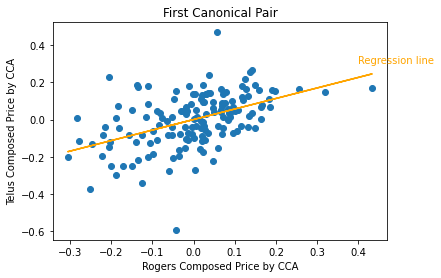

In [473]:
fig, ax = plt.subplots()

x = X_c[:,0]
y = Y_c[:,0]

ax.scatter(x, y)
# Add the regression line:
m, b = np.polyfit(x, y, 1)
ax.plot(x, m * x + b, color="orange")
style = dict(size=10, color='orange')
ax.text(0.4, 0.3, "Regression line", **style)


ax.set_title("First Canonical Pair")
ax.set_xlabel("Rogers Composed Price by CCA")
ax.set_ylabel("Telus Composed Price by CCA")
plt.show()

In [474]:
for i in range(X_c.shape[1]):
    print("Correlation of No.{} canonical pair: {}".format(i+1, np.corrcoef(X_c[:,i], Y_c[:,i])[0, 1]))

CCA_first_corr = np.corrcoef(X_c[:,0], Y_c[:,0])[0, 1]
print("Based on the first CCA pair:")
if abs(CCA_first_corr) < 0.1:
    print("Basically there is no correlation effect between them.")
elif abs(CCA_first_corr) < 0.3:
    print("The correlation effect between them is relatively week.")
elif abs(CCA_first_corr) < 0.5:
    print("The correlation effect between them is moderate.")
else:
    print("The correlation effect between them is relatively strong.")

Correlation of No.1 canonical pair: 0.4752924624865021
Correlation of No.2 canonical pair: 0.2960467780312311
Based on the first CCA pair:
The correlation effect between them is moderate.


Take a view on its correlation matrix:

In [475]:
cr = df_telecom.iloc[:, 1:].corr(method="pearson")
fig = go.Figure(go.Heatmap(x=cr.columns, y=cr.columns,
                           z=cr.values.tolist(), colorscale="rdylgn",
                           zmin=-1, zmax=1))
fig.update_layout(title_text="Stock Price Correlation Matrix between Rogers(x) and Telus(y)")

fig.update_xaxes(title_text="Rogers price")
fig.update_yaxes(title_text="Telus price")

fig.show()

The corrlation between each price pair from different company is around 0.15, which shows that there is a weak effect between them. Considered that the correlation of No.1 canonical pair is around 0.48, these two telecom companies appear the similar trends to a certain extent. However, the further analysis still need to be impletmented to identify the potential patterns.